# Import

In [1]:
# %pip install pandas
# %pip install pm4py
# %pip install psutil
# %pip install matplotlib
# %pip install seaborn
# %pip install holidays
# %pip install scikit-learn
# %pip install collection
# %pip install scipy

import pandas as pd
import pm4py as pm
import numpy as np
import psutil as pu

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import holidays

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


from collections import defaultdict

from scipy import stats

training_file_path = 'db/BPI_Challenge_2012.XE-training.csv'
testing_file_path = 'db/BPI_Challenge_2012.XE-test.csv'
nl_holidays = holidays.country_holidays('NL')
holidays_keys = nl_holidays.keys()
holiday_list = [i for i in nl_holidays.keys()]

# load CSV with pandas and pm4py

pm4py gives two extra columns: @@index and @@case_index

In [2]:
def format_event_log(path):
    event_log = pd.read_csv(path, sep=',')
    event_log = pm.format_dataframe(
        event_log, 
        case_id='case concept:name', 
        activity_key='event concept:name', 
        timestamp_key='event time:timestamp'
    )
    event_log = event_log.drop("case:concept:name", axis = 1)
    event_log = event_log.drop("concept:name", axis = 1)
    event_log = event_log.drop("time:timestamp", axis = 1)
    return event_log
#event_log

# Helper methods

## Genernal

Function that finds the length of the longest trace in a list of traces

In [3]:
def find_longest_trace(traces):
    max = 0
    for trace in traces:
        if trace.shape[0] > max:
            max = trace.shape[0]
    return max

def get_all_Activities():
    df = format_event_log(training_file_path)
    arr = df['event concept:name'].unique()
    return arr

## Sprint 1

Function that adds the time difference from the last event in the trace column in the data set for time prediction

In [4]:
# assume sorted by caseID and time
def caseHasNextEvent(df, index):
    if index >= len(df) - 1:
        return False
    if df.loc[index, 'case concept:name'] == df.loc[index+1, 'case concept:name']:
        return True
    return False


def computeTimeDifference(df):
    # df['time_until_next_event'] = 0  # initialize new column with zeros
    df = df.assign(ground_truth_time=0) # initialize new column

    # iterate over each row of the dataframe
    for i, row in df.iterrows():        
        # check if there is a next row with the same case
        if caseHasNextEvent(df, i):
            nextTime = df.loc[i+1, 'event time:timestamp']
            currentTime = row['event time:timestamp']
            timeDiff = nextTime - currentTime
            df.at[i, 'ground_truth_time'] = timeDiff.total_seconds()
    
    return df



Function to write ground truth column in the data set for verification purposes.

In [5]:

def writeGroundtruth(df):
    df = df.sort_values(by=['case concept:name','event time:timestamp'])
    #add new columns containing the name of the next event in the case and the time when it happens
    df = df.assign(ground_truth_activity='')
    df = df.assign(ground_truth_time='')

    for ind in df.index:
        if caseHasNextEvent(df, ind):
            df.at[ind,'ground_truth_activity'] = df.loc[ind+1,'event concept:name']
            #df.at[ind,'ground_truth_time'] = df.loc[ind+1, 'event time:timestamp']
        else:
            df.at[ind,'ground_truth_activity'] = None
            #df.at[ind,'ground_truth_time'] = None
    df = computeTimeDifference(df)
    return df

#df_event = writeGroundtruth(event_log)
#df_event.to_csv('check_writeGroundtruth_out.csv')

## Sprint 2

Function that splits the data set into separate traces
- Parameter $traces$ is a list containing all the individual traces
- Each trace in traces is a list containing all the events in the trace in the order that they happen
- Helper method for prefix extraction

In [6]:
def split_into_traces(event_log):
    traces = []
    last_location = 0
    for j in range (0, event_log.shape[0] - 1):
        if not event_log["case concept:name"][j] == event_log["case concept:name"][j + 1]:
            traces.append(event_log.loc[last_location : j].reset_index())
            last_location = j + 1
    traces.append(event_log.loc[last_location : event_log.shape[0] - 1].reset_index())
    return traces

Function that deletes traces from an event log that do not end before a specified time

In [7]:
def delete_overlapping_traces(event_log, end_time):
    traces = split_into_traces(event_log)
    del_tr = []
    for j in range(len(traces)):
        for k in traces[j].index:
            trace_ts = traces[j]["event time:timestamp"][k]
        if trace_ts > end_time:
            del_tr.append(traces[j]["case concept:name"][0])
    
    for j in range(len(del_tr)):
        event_log = event_log[event_log["case concept:name"] != del_tr[j]]
    event_log.to_csv("db/S2_Remove_Overlap.csv")
    return event_log.reset_index(drop=True)

Prefix extraction
- extract event lists of all lengths store in the prefix_lengts, from the traces for prediction
- store them in a list of prefixes

In [8]:
def prefix_extraction(traces, prefix_lengths):
    prefixes = []
    for trace in traces:
        for length in prefix_lengths:
            if trace.shape[0] >= length:
                prefixes.append(trace.loc[:length - 1])
    return prefixes

Regression helper methods

In [9]:
# dict_independent_variable should have index as activities
# and with a value of a discrete number.
def process_X_Y(df, str_DV_col, dict_independent_variable):
    independent_Variable = get_all_Activities()
    independent_Variable = np.append(['hollidays', 'last_event'], independent_Variable)
    dependent_Variable = str_DV_col

    
    X = df[independent_Variable]
    if str_DV_col == "ground_truth_activity":
        Y = df[dependent_Variable].replace(dict_independent_variable)
    elif str_DV_col == "ground_truth_time":
        Y = df[dependent_Variable]

    return X, Y

def get_Regression_model_and_scaler(X, Y, type):

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    if type == "Logistic":
        model = LogisticRegression()
        Y = Y.fillna(0.0)
    elif type == "Linear":
        model = LinearRegression()
        Y = Y.fillna(0.0)


    model.fit(X, Y)
    
    intercept = model.intercept_

    return model, scaler

## Sprint 3

isHolliday helper method

In [10]:
def isHoliday(timestamp):
    if timestamp.weekday() in [5, 6] or timestamp.date() in holiday_list:
        return 1
    else: return 0

helper method to get the needed dictionaries

In [11]:
def get_IV_dict():
    IV_list = get_all_Activities().tolist()
    return {
        a: IV_list.index(a) for a in IV_list
    }

def get_IV_dict_invert():
    IV_dict = get_IV_dict()
    return {v: k for k, v in IV_dict.items()}


Decision tree helper method

In [12]:
def get_Decision_tree_model_and_scaler(X, Y, type):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    if type == 'activity':
        model = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=1)
    elif type == 'time':
        model = DecisionTreeRegressor(criterion='absolute_error', max_depth=10, random_state=1)

    Y = Y.fillna(0.0)

    # print(Y)
    model.fit(X, Y)
    
    return model, scaler

Function that deletes the outliers based on the zscore`

In [13]:
def delete_outliers(event_log):
    traces = split_into_traces(event_log)
    del_trace = []
    trace_len = []
    for j in range(1, len(traces)):
        trace_len.append(traces[j].size)

    df_len = pd.DataFrame(trace_len)
    df_len = df_len[(np.abs(stats.zscore(df_len[0])) > 3)]

    for ind in df_len.index:
        del_trace.append(traces[ind]["case concept:name"][0])

    for j in range(len(del_trace)):
        event_log = event_log[event_log["case concept:name"] != del_trace[j]]
    event_log.to_csv("db/S2_Remove_Overlap.csv")
    return event_log.reset_index(drop=True)

## Aggregation functions

Aggregation encoding

- encode traces into numerical data for prediction
- adds the ground truth at the start of the encoded prefix
- adds the hollidays and last_event features at the end of the encoding

In [14]:
def create_dict(events):

    events_dict = {'ground_truth_activity' : 'truth', 'ground_truth_time' : 'truth'}
    for event in events:
        events_dict[event] = 0
    events_dict['hollidays'] = 0
    events_dict['last_event'] = 0
    return events_dict

def aggregation_encoding(prefixes, event_log):
    events = get_all_Activities()
    event_dict = create_dict(events)
    last_event_dict = get_IV_dict()
    aggregation_encoding = pd.DataFrame(event_dict, index=[0])
    aggregation_encoding = aggregation_encoding.drop(0)
    #new_encoding = ['truth', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    index = 0
    for prefix in prefixes:
        current_dict = create_dict(events)
        current_dict['ground_truth_activity'] = prefix['ground_truth_activity'][len(prefix.index) - 1]
        current_dict['ground_truth_time'] = prefix['ground_truth_time'][len(prefix.index) - 1]
        current_dict['last_event'] = last_event_dict[prefix["event concept:name"][len(prefix.index) - 1]]
        for j in range (prefix.shape[0]):
            if isHoliday(prefix["event time:timestamp"][j]):
                current_dict['hollidays'] = current_dict['hollidays'] + 1
            current_dict[prefix["event concept:name"][j]] = current_dict[prefix["event concept:name"][j]] + 1
        aggregation_encoding.loc[index] = current_dict.values()
        index += 1
    return aggregation_encoding

Apply the necesary changes to the event log and do all the steps in order to aggregate a file

In [15]:
def get_aggregation_encoding(path, type):
    event_log = format_event_log(path)
    if type == "train":
        time_split = pd.to_datetime("02-01-2012 15:28:39.244",format="%d-%m-%Y %H:%M:%S.%f")
        event_log = delete_overlapping_traces(event_log, pd.Timestamp(time_split, tz='GMT+0'))
        event_log = delete_outliers(event_log)
        event_log = format_event_log("db/S2_Remove_Overlap.csv")
    traces = split_into_traces(event_log)
    prefix_lengths = []
    if type == "train":
        prefix_lengths = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
    if type == "test":
        prefix_lengths = [x for x in range(1, find_longest_trace(traces) + 1)]
    prefixes = prefix_extraction(traces, prefix_lengths)
    aggregation = aggregation_encoding(prefixes, event_log)
    if type == "train":
        aggregation.to_csv("db/aggregation_encoding_train.csv")
    if type == "test":
        aggregation.to_csv("db/aggregation_encoding_test.csv")
    return aggregation
     

Create the aggregations for the train and the test files

In [16]:
def write_aggregation():
    train_file_path = 'db/S1_GroundTruth.csv'
    test_file_path = 'db/S2_Aggregation_Estimator.csv'
    train_aggregation = get_aggregation_encoding(train_file_path, "train")
    test_aggregation = get_aggregation_encoding(test_file_path, "test")

# Naive Estimator (S1)
- used indications on canvas
- order train and test set by "case concept:name" and "event time:timestamp" columns 
- split train set into traces
- find the length of the longest trace (N)
- for each position i (from 1..N) find out the most commun activity that happened in each trace at position i at the most commun time difference between position i and position i-1 in each trace
- add this data to the test set

In [17]:
def naive_estimators():
    df_train = format_event_log(training_file_path)
    df_train = writeGroundtruth(df_train)

    df_test = format_event_log(testing_file_path)
    df_test = writeGroundtruth(df_test)

    traces = split_into_traces(df_train)
    N = find_longest_trace(traces)
    
    common_activities = []
    common_times = []
    for i in range (0, N):
        activity_at_position_i = defaultdict(int)
        for trace in traces:
            if (i < trace.shape[0]):
                activity_at_position_i[trace["event concept:name"][i]] += 1
        common_activities.append(max(activity_at_position_i, key=lambda k: activity_at_position_i[k]))

        time_at_position_i = defaultdict(int)
        for trace in traces:
            if (i < trace.shape[0]):
                time_at_position_i[trace["ground_truth_time"][i]] += 1
                
        common_times.append(max(time_at_position_i, key=lambda k: time_at_position_i[k]))

    activity_predictions = []
    time_predictions = []
    index = 0
    for j in range (0, df_test.shape[0] - 1):
        if df_test["case concept:name"][j] == df_test["case concept:name"][j + 1]:
            activity_predictions.append(common_activities[index])
            time_predictions.append(common_times[index])
            index += 1
        else:
            activity_predictions.append(common_activities[index])
            time_predictions.append(common_times[index])
            index = 0
    activity_predictions.append(common_activities[index])
    time_predictions.append(common_times[index])
    df_test["S_1_Activity"] = activity_predictions
    df_test["S_1_Time"] = time_predictions
    df_train.to_csv("db/S1_GroundTruth.csv")
    df_test.to_csv("db/S1_Naive_estimator.csv")


# Mode Estimator (S2)
1. for each row find next activity of the case and its timestamp
2. compute the time it take for the next event to be log in the db
3. for each activity find the most common next activity (mode)
4. for each activity find the average time between next activity
5. Have 3. and 4. in a DataFrame
6. base on the current activity write the prediction of the next activity and time it will take

In [18]:
def mode_estimators():

    s2_train_file_path = "db/S1_GroundTruth.csv"
    s2_test_file_path = "db/S1_Naive_estimator.csv"

    df_train = format_event_log(s2_train_file_path)
    df_test = format_event_log(s2_test_file_path)

    holiday_train = []
    for index in range (df_train.shape[0]): 
        if isHoliday(df_train["event time:timestamp"][index]):
            holiday_train.append(1)
        else:
            holiday_train.append(0)

    holiday_test = []
    for index in range (df_test.shape[0]): 
        if isHoliday(df_test["event time:timestamp"][index]):
            holiday_test.append(1)
        else:
            holiday_test.append(0)

    df_train['isHoliday'] = holiday_train
    df_test['isHoliday'] = holiday_test

    df_look_up_dict_activity =  df_train.groupby(['event concept:name', 'isHoliday']).agg(
        Activity_Pretiction = ('ground_truth_activity', pd.Series.mode)
    ).unstack()
    df_look_up_dict_time = df_train.copy().groupby(['event concept:name', 'isHoliday']).agg(
        Time_Pretiction = ('ground_truth_time', 'mean')
    ).unstack()


    df_test = df_test.assign(S_2_Activity='')
    df_test = df_test.assign(S_2_Time=0)
    for i, r in df_test.iterrows():
        this_activity = r['event concept:name']
        this_isHoliday = r['isHoliday']
        next_event = df_look_up_dict_activity.loc[this_activity, ('Activity_Pretiction', this_isHoliday)]
        next_time = df_look_up_dict_time.loc[this_activity, ('Time_Pretiction', this_isHoliday)]

        df_test.at[i,'S_2_Activity'] = next_event
        df_test.at[i,'S_2_Time'] = next_time

    df_test = df_test.drop('isHoliday', axis = 1)
    df_test.to_csv('db/S2_Aggregation_Estimator.csv')


    

# Multivalue Regression (S3)

1. Set up the training and testing aggregation encoding in two df
2. Seet up the Dictionaray for converting activities to integer
3. process the X Y value for both training and testing set
4. call the '''get_Regression_model_and_scaler()''' with training values to get the model and the saler
5. use the model to predict the activites in the testing set
6. convert the prediction from integer back to activities(str) using the dictionary from step 2
7. repeat step from 3. to 5. for time prediction

For the activity prediction we use LogisticRegression() in the sklearn libeary, whereas we use LinearRegression() for the time prediction

In [19]:
def regression_estimator():
    df_encoded_train = pd.read_csv('db/aggregation_encoding_train.csv')
    df_encoded_test = pd.read_csv('db/aggregation_encoding_test.csv')
    
    df_output = format_event_log('db/S2_Aggregation_Estimator.csv')
    
    independent_Variable = get_all_Activities().tolist()
    dict_IV_index_activities = {
        a: independent_Variable.index(a) for a in independent_Variable
    }
    dict_IV_invert = {v: k for k, v in dict_IV_index_activities.items()}
    # ========================================================================================== 
    X_train_activity, Y_train_activity = process_X_Y(df_encoded_train, "ground_truth_activity", dict_IV_index_activities)
    X_test_activity, Y_test_activity = process_X_Y(df_encoded_test, "ground_truth_activity", dict_IV_index_activities)

    model_activity, scaler_activity = get_Regression_model_and_scaler(
        X_train_activity, 
        Y_train_activity, 
        "Logistic"
    )

    X_test_activity = scaler_activity.transform(X_test_activity)

    predicts_activity = model_activity.predict(X_test_activity)
    predicts_activity = [dict_IV_invert[p] for p in predicts_activity]

    # ===========================================================================================
    X_train_time, Y_train_time = process_X_Y(df_encoded_train, "ground_truth_time", dict_IV_index_activities)
    X_test_time, Y_test_time = process_X_Y(df_encoded_test, "ground_truth_time", dict_IV_index_activities)
    model_time, scaler_time = get_Regression_model_and_scaler(
        X_train_time,
        Y_train_time,
        "Linear"
    )
    X_test_time = scaler_time.transform(X_test_time)
    predicts_time = model_time.predict(X_test_time)

    df_output['S_3_activities'] = predicts_activity
    df_output['S_3_time'] = predicts_time
    df_output.to_csv("db/S3_Regression_Estimator.csv")



# Decision Tree Estimator (S4)

The step to get this estimator is almost exactly the same as regression estimator, except we are using DecisionTreeClassifier() for activity prediction and DecisionTreeRegressor() for time prediction.

In [20]:
def decision_tree_estimator():
    df_encoded_train = pd.read_csv('db/aggregation_encoding_train.csv')
    df_encoded_test = pd.read_csv('db/aggregation_encoding_test.csv')
    
    df_output = format_event_log('db\S3_Regression_Estimator.csv')
    
    independent_Variable = get_all_Activities().tolist()
    dict_IV_index_activities = get_IV_dict()
    dict_IV_invert = get_IV_dict_invert()
    # ========================================================================================== 
    X_train_activity, Y_train_activity = process_X_Y(df_encoded_train, "ground_truth_activity", dict_IV_index_activities)
    X_test_activity, Y_test_activity = process_X_Y(df_encoded_test, "ground_truth_activity", dict_IV_index_activities)

    model_activity, scaler_activity = get_Decision_tree_model_and_scaler(
        X_train_activity, 
        Y_train_activity,
        'activity'
    )

    X_test_activity = scaler_activity.transform(X_test_activity)

    predicts_activity = model_activity.predict(X_test_activity)
    predicts_activity = [dict_IV_invert[p] for p in predicts_activity]
    
    df_output['S_4_activities'] = predicts_activity


    # ========================================================================================== 
    X_train_time, Y_train_time = process_X_Y(df_encoded_train, "ground_truth_time", dict_IV_index_activities)
    X_test_time, Y_test_time = process_X_Y(df_encoded_test, "ground_truth_time", dict_IV_index_activities)

    model_time, scaler_time = get_Decision_tree_model_and_scaler(
        X_train_time, 
        Y_train_time,
        'time'
    )

    X_test_time = scaler_activity.transform(X_test_time)

    predicts_time = model_activity.predict(X_test_time)

    df_output['S_4_time'] = predicts_time

    df_output.to_csv("db/S4_Decision_Tree_Estimator.csv")


# Other Functionalities

## Visualisation

Scatterplot representation of the entire data set in chronological order

In [21]:
def plot_all_data():
    df_BPI_train = pd.read_csv(training_file_path)
    df_BPI_test = pd.read_csv(testing_file_path)
    df_BPI = pd.concat([df_BPI_train, df_BPI_train])
    
    df_BPI['event time:timestamp'] = pd.to_datetime(df_BPI['event time:timestamp'],format="%d-%m-%Y %H:%M:%S.%f")
    
    ax = sns.relplot(data=df_BPI, x='event time:timestamp', y='case concept:name', hue='event concept:name', height=10, aspect=1.5)
    plt.ylim(max(df_BPI['case concept:name']), min(df_BPI['case concept:name']))
    plt.show()

Scatterplot representation of the data set split into training and test sets, after the removal of unusable traces from the training set

In [22]:
def plot_split_data():
    df_BPI_train = pd.read_csv(training_file_path)
    df_BPI_test = pd.read_csv(testing_file_path)
    df_BPI = pd.concat([df_BPI_train, df_BPI_train])
    
    df_BPI['event time:timestamp'] = pd.to_datetime(df_BPI['event time:timestamp'],format="%d-%m-%Y %H:%M:%S.%f")
    df_BPI['case REG_DATE'] = pd.to_datetime(df_BPI['case REG_DATE'],format="%d-%m-%Y %H:%M:%S.%f")
    splittime = pd.to_datetime("02-01-2012 15:28:39.244",format="%d-%m-%Y %H:%M:%S.%f")
    plt_splitline = df_BPI.copy()
    plt_splitline['event time:timestamp'] = splittime
    plt_splitline['event concept:name'] = "test/training split"
    
    df_BPI = df_BPI.sort_values(by=['case concept:name','event time:timestamp'], ignore_index=True)
    df_BPI_train = delete_overlapping_traces(df_BPI.copy(), splittime)
    df_BPI_test = df_BPI[df_BPI['case REG_DATE'] >= splittime]
    
    df_BPI = pd.concat([df_BPI_train, df_BPI_test])
    df_BPI = df_BPI.sort_values(by='event time:timestamp', ignore_index=True)
    df_BPI = pd.concat([df_BPI, plt_splitline])
    
    ax = sns.relplot(data=df_BPI, x='event time:timestamp', y='case concept:name', hue='event concept:name', height=10, aspect=1.5)
    plt.ylim(max(df_BPI['case concept:name']), min(df_BPI['case concept:name']))
    plt.show()

Scatterplot representation of the data set with time arrangement of events relative to the start of their respective case

In [23]:
def plot_case_relative():
    df_BPI_train = pd.read_csv(training_file_path)
    df_BPI_test = pd.read_csv(testing_file_path)
    df_BPI = pd.concat([df_BPI_train, df_BPI_train])
    
    df_BPI['event time:timestamp'] = pd.to_datetime(df_BPI['event time:timestamp'],format="%d-%m-%Y %H:%M:%S.%f")
    df_BPI['case REG_DATE'] = pd.to_datetime(df_BPI['case REG_DATE'],format="%d-%m-%Y %H:%M:%S.%f")
    
    df_BPI['event time:case relative'] = pd.to_datetime(df_BPI['event time:timestamp'], format="%Y-%m-%d %H:%M:%S.%f") - pd.to_datetime(df_BPI['case REG_DATE'], format="%Y-%m-%d %H:%M:%S.%f")
    
    ax = sns.relplot(data=df_BPI, x='event time:case relative', y='case concept:name', hue='event concept:name', markers="x", height=7, aspect=1.5)
    plt.ylim(max(df_BPI['case concept:name']), min(df_BPI['case concept:name']))
    plt.xlim(0, )
    plt.show()

## Error model

Scatter Plot representation of the time error of the currently checked model

In [24]:
def error_visualisation_time(df, prediction_time):
    df['ground_truth_time'] = df['ground_truth_time'] / 3600
    df[prediction_time] = df[prediction_time] / 3600
    
    x1 = df['ground_truth_time']
 
    y1 = df.index
 
    x2 = df[prediction_time]
 
    y2 = df.index
 
    plt.scatter(x1, y1, c ="green",
                linewidths = 2,
                marker ="s",
                s = 10)
    
    plt.scatter(x2, y2, c ="red",
                linewidths = 2,
                marker ="^",
                s = 10)
    
    plt.xlabel("Time (Hours)")
    plt.ylabel("EventID")
    plt.ylim(200, 300)
    plt.xlim(-2, 200)
    plt.show()

Scatter Plot representation of the time error of all models

In [25]:
def error_visualisation_time_all():
    df_error_model_1 = pd.read_csv('db/S1_Naive_estimator.csv')
    df_error_model_1 = df_error_model_1.fillna('None')
    
    df_error_model_2 = pd.read_csv('db/S2_Aggregation_Estimator.csv')
    df_error_model_2 = df_error_model_2.fillna('None')
    
    df_error_model_3 = pd.read_csv('db/S3_Regression_Estimator.csv')
    df_error_model_3 = df_error_model_3.fillna('None')
    
    df_error_model_4 = pd.read_csv('db/S4_Decision_Tree_Estimator.csv')
    df_error_model_4 = df_error_model_4.fillna('None')
    
    df_error_model_1['ground_truth_time'] = df_error_model_1['ground_truth_time'] / 3600
    df_error_model_1['S_1_time'] = df_error_model_2['S_1_Time'] / 3600
    df_error_model_2['S_2_time'] = df_error_model_2['S_2_Time'] / 3600
    df_error_model_3['S_3_time'] = df_error_model_3['S_3_time'] / 3600
    df_error_model_4['S_4_time'] = df_error_model_4['S_4_time'] / 3600
    
    x1 = df_error_model_2['ground_truth_time']
    y1 = df_error_model_1.index
    
    x5 = df_error_model_1['S_1_Time']
 
    x2 = df_error_model_2['S_2_Time']
    
    x3 = df_error_model_3['S_3_time']
    
    x4 = df_error_model_4['S_4_time']
 
    plt.scatter(x1, y1, c ="green",
                linewidths = 2,
                marker ="s",
                s = 10)
    
    plt.scatter(x5, y1, c ="blue",
                linewidths = 2,
                marker ="^",
                s = 10)
    
    plt.scatter(x2, y1, c ="red",
                linewidths = 2,
                marker ="^",
                s = 10)
    
    plt.scatter(x3, y1, c ="purple",
                linewidths = 2,
                marker ="^",
                s = 10)
    
#     plt.scatter(x4, y1, c ="orange",
#                 linewidths = 2,
#                 marker =".",
#                 s = 10)
    
    plt.xlabel("Time (Hours)")
    plt.ylabel("EventID")
    plt.ylim(200, 300)
    plt.xlim(-2, 200)
    plt.show()

Heatmap Representing a Confusion Matrix for our activity predictions

In [26]:
def error_visualisation_activity(prediction_path, df, prediction_activity):
    cm = confusion_matrix(df['ground_truth_activity'], df[prediction_activity])
    plt.figure(dpi =1200)
    labels = np.array(['A_ACCEPTED','A_ACTIVATED','A_APPROVED', 'A_CANCELLED','A_DECLINED','A_FINALIZED',
                       'A_PARTLYSUBMITTED','A_PREACCEPTED','A_REGISTERED','NaN','A_SUBMITTED','O_ACCEPTED',
                       'O_CANCELLED','O_CREATED','O_DECLINED','O_SELECTED','O_SENT','O_SENT_BACK',
                       'W_Afhandelen leads','W_Beoordelen fraude','W_Completeren aanvraag',
                       'W_nabellen incomplete dossiers','W_nabellen offertes','W_valideren aanvraag',])
    sns.heatmap(cm,
            annot=True, 
            annot_kws={"size":5},
            fmt='g',
            xticklabels=labels,
            yticklabels=labels)
    plt.ylabel('Actual',fontsize=7)
    plt.xlabel('Predicted',fontsize=7)
    plt.title(prediction_path,fontsize=10)
    plt.tick_params(labelsize=5)
    plt.show()

Finds the Accuracy of the activity prediction model

In [27]:
def error_activity(df, prediction_activity):
    df['error_activity'] = df['ground_truth_activity'] == df[prediction_activity]
    correct_predictions = df['error_activity'].value_counts()
    percentage = correct_predictions[True] / len(df['error_activity']) * 100
    print(f'Percentage of True values: {percentage:.1f}%')

Find the absolute mean error of the time prediction model

In [28]:
def error_time(df, prediction_time):
    df['error_time'] = df[prediction_time] - df['ground_truth_time']
    mean_absolute_error = df['error_time'].mean()
    print(abs(mean_absolute_error))

Runs all the methods to see error of each model

In [29]:
def error_model(predictor_path, prediction_activity, prediction_time):
    df_error_model = pd.read_csv(predictor_path)
    df_error_model = df_error_model.fillna('None')
    error_activity(df_error_model, prediction_activity)
    error_time(df_error_model, prediction_time)
    error_visualisation_time(df_error_model, prediction_time)
    error_visualisation_activity(predictor_path, df_error_model, prediction_activity)

# Main class
1. All functions that are needed all called in this cell.
2. No other cell runs code other than the main cell.

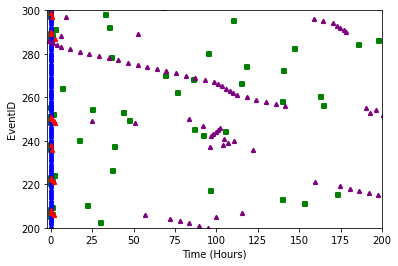

In [31]:
# naive_estimators()
# mode_estimators()
# write_aggregation()
# regression_estimator()
# decision_tree_estimator()
# error_model('db/S3_Regression_Estimator.csv', 'S_3_activities', 'S_3_time')
# error_model('db/S2_Aggregation_Estimator.csv', 'S_2_Activity', 'S_2_Time')
error_visualisation_time_all()
